## Intro

- Notebook for creating and training a variational autoencoder to use with the toy sequence dataset
 - To create the dataset, run toy_data_dataset.ipynb
- Settings in the Parameters section (below) are used in creating and training the network  
 - Comment one of the versions (Full/Quick) of settings out below, or set them how you like

## Parameters

In [1]:
import tensorflow as tf

save_loc = "saved/toy_seqs"



## Full
reps = 1  # number of times to try each parameter setting 
ep = 60  # max epochs 
EARLY_STOP = 3  # stop if no improvement in this many epochs
BATCH_SIZE= 32    # batch size

layer_size_options = [[256, 16], [512, 64, 16], [1024, 64]]
latent_dim_options = [4, 6, 8]
learning_rate_options = [5e-5]
optimizer_options = [tf.keras.optimizers.Adam]


# Quick 
reps = 1
ep = 3 
EARLY_STOP = 3
BATCH_SIZE= 32

layer_size_options = [[256, 16]]
latent_dim_options = [4]
learning_rate_options = [5e-5]
optimizer_options = [tf.keras.optimizers.Adam]



## Imports

In [2]:
import numpy as np


import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
from my_lib.save_load import load_datasets, save_seq_vae
from my_lib.models.vae_sequence import VAE, SCALE, START, loss_function, acc_metric

# Load data

In [3]:
all_data = load_datasets(save_loc)
bs = BATCH_SIZE
print("\nColumns of s are: start, stop, step, length\n")
for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)
    
max_len = max(s_tr[:,-1])
print("\nMax seq lenght is", max_len)

failed to load .ipynb_checkpoints (This is probably fine, unless it's needed)

Columns of s are: start, stop, step, length

initialized variable, s_cv
initialized variable, s_tr

Max seq lenght is 29.0


In [4]:
all_seqs = []
for s in (s_tr, s_cv):
    eff_stops = s[:,0] + s[:, 2]*max_len
    expanded_seqs = [(x[0],eff_s, x[2] ) for x, eff_s in zip(s, eff_stops)]
    all_seqs.append(expanded_seqs)
    
    
all_seqs_tr, all_seqs_cv = all_seqs

### Create datasets

In [5]:
input_tensor_train = tf.keras.preprocessing.sequence.pad_sequences([np.arange(*x) for x in all_seqs_tr], 
                                                          padding='post')
input_tensor_train.shape

(95000, 29)

In [6]:
input_tensor_val = tf.keras.preprocessing.sequence.pad_sequences([np.arange(*x) for x in all_seqs_cv], 
                                                          padding='post')
input_tensor_val.shape

(5000, 29)

In [7]:
input_tensor_train = tf.cast(input_tensor_train.reshape(*input_tensor_train.shape, 1), tf.float32)
input_tensor_val = tf.cast(input_tensor_val.reshape(*input_tensor_val.shape, 1), tf.float32)


seq_lens_train = tf.constant(s_tr[:,-1], dtype=tf.float32)
seq_lens_val = tf.constant(s_cv[:,-1], dtype=tf.float32)

In [8]:


dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train/SCALE, seq_lens_train)) \
                         .shuffle(len(input_tensor_train)) \
                         .batch(BATCH_SIZE, drop_remainder=True)

dataset_cv = tf.data.Dataset.from_tensor_slices((input_tensor_val/SCALE, seq_lens_val)) \
                            .shuffle(len(input_tensor_val)) \
                            .batch(BATCH_SIZE, drop_remainder=True)


# Define network training

In [9]:
def show_reconsturction(ae, max_show=10, teacher_forcing=True, cv_data=True):

    encoder= ae.encoder
    decoder = ae.decoder
    BATCH_SIZE = 32
    sentances = [[] for _ in range(BATCH_SIZE)]

    if cv_data:
        for (inp, true_lens) in dataset_cv: break # hacky way to get inp, targ
    else:
        for (inp, true_lens) in dataset: break # hacky way to get inp, targ
    to_translate = np.zeros(inp.shape)

    loss = 0
    acc = tf.constant([0,0], dtype=tf.float32)

    masked_inp = inp*tf.expand_dims(tf.sequence_mask(true_lens, dtype=tf.float32, maxlen=inp.shape[1]),-1)
    context, _, _  = encoder(masked_inp)
    
    dec_input = tf.expand_dims([START] * ae.batch_size, 1)
    dec_hidden = ae.initialize_hidden_state()

    pred_list = []
    pred_lens = tf.minimum(tf.round(ae.len_decoder(context)),inp.shape[1])

    # Teacher forcing - feeding the target as the next input
    for t in range(inp.shape[1]):
        # passing enc_output to the self.decoder
        predictions, dec_hidden, = decoder((dec_input, context, dec_hidden))

        loss += loss_function(inp[:, t], predictions , pred_lens)
        acc += acc_metric(inp[:, t], predictions)

        # using teacher forcing
        
        to_translate[:,t] = predictions
        
        if teacher_forcing:
            dec_input = inp[:, t]
        else:
            dec_input = predictions
            
        pred_list.append(predictions)

    batch_loss = (loss / int(inp.shape[1]))

    
    print("*"*100)
    print("acc", 1- acc[0]/acc[1])
    print("\n")
    
    
    for i in range(min(max_show, len(inp))):

        true = [x[0] for x in tf.round(inp[i]*SCALE).numpy() ]#if x[0] > 0]
        pred = [x[0] for x in tf.round(to_translate[i]*SCALE).numpy()] #[:int(pred_lens[i])]

        true_fin = False
        pred_fin = False

        for seq_i, (t,p) in enumerate(zip(true, pred)):
            if seq_i < true_lens[i]: 
                t = str(int(t))
            else:
                t = "   "
                true_fin = True
            if seq_i < pred_lens[i]:
                p = str(int(p))
            else:
                p = "   "
                pred_fin = True

            if true_fin and pred_fin:
                break

            print("{} ----> {}".format(t, p))

        true_s = "\t".join(map(str,map(int, true)))
        pred_s = "\t".join(map(str,map(int, pred)))


        print()
        print("true step:", true[1]-true[0])
        print("mean pred step {:.2f}".format(np.mean(np.diff(pred[:int(pred_lens[i])]))))
        print("median pred step {:.2f}".format(np.median(np.diff(pred[:int(pred_lens[i])]))))

        tl = true_lens[i].numpy()
        pl = pred_lens[i].numpy()[0]
        print("True length:",  tl)
        print("Predicted length:", pl)

        print("\n", "*"*100 ,"\n")

In [10]:


def train_ae(ae, EPOCHS, EARLY_STOP=4, ppe = 2, no_tf_p=0.02, big_update_every=4):
    
    steps_per_epoch = len(dataset) 
    steps_per_epoch_cv = len(dataset_cv) 
    
    print_every = steps_per_epoch // ppe
    full_start = time.time()
    
    for epoch in range(EPOCHS):
        update_count = 0 
        start = time.time()

        total_loss, cv_total_loss = 0, 0
        total_acc, cv_total_acc = 0,0

        for (batch, (inp, targ)) in enumerate(dataset):
            
            # randomly choose if using teacher forcing
            if np.random.random() > no_tf_p:
                batch_loss, batch_mets = ae.train_step(inp, targ)
            else:
                batch_loss, batch_mets = ae.train_step_tf(inp, targ)

            total_loss += batch_loss


            if batch % print_every == 0:
                update_count += 1
                print('Epoch {} update {} (Batch {}) Loss {:.4f}'.format(epoch + 1,
                                                                         update_count,
                                                             batch,
                                                             batch_loss.numpy()))
                
                for name, val in batch_mets:
                    print('Epoch {} update {} (Metric={}) val={:.4f}'.format(epoch + 1,
                                                                            update_count,
                                                     name,
                                                     val))
                
            

        print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch) )
        print('Epoch {} Acc {:.4f}'.format(epoch + 1, total_acc / steps_per_epoch))

        ae.track["loss_tr"].append(total_loss / steps_per_epoch)
        ae.track["acc_tr"].append(total_acc / steps_per_epoch)


        for (batch, (inp, targ)) in enumerate(dataset_cv.take(steps_per_epoch_cv)):

            batch_loss, batch_mets = ae.cv_step(inp, targ)
            cv_total_loss += batch_loss  

            if batch == 0:
                cv_info = {}
                for name, val in batch_mets:
                    name = name.numpy().decode("utf-8")
                    cv_info[name] = val                    
            else:
                for name, val in batch_mets:
                    name = name.numpy().decode("utf-8")
                    cv_info[name] += val
                

        print('**CV** Epoch {} Loss {:.4f}'.format(epoch + 1, cv_total_loss / steps_per_epoch_cv))

        ae.track["loss_cv"].append(cv_total_loss / steps_per_epoch_cv)
        
        for name, val in cv_info.items():


            print('Epoch {} update {} (Metric={}) val={:.4f}'.format(epoch + 1,
                                                                    update_count,
                                                                     name,
                                                                     val / steps_per_epoch_cv))


        print('Time taken for 1 epoch {} sec\n\n'.format(time.time() - start))
        


        if len(ae.track["loss_cv"]) > EARLY_STOP and min(ae.track["loss_cv"]) < min(ae.track["loss_cv"][-EARLY_STOP:]):
            print("\nEarly stop, best loss", min(ae.track["loss_cv"]), "last", EARLY_STOP, ae.track["loss_cv"][-EARLY_STOP:])
            break 

            
        if big_update_every:
            if epoch % big_update_every == 0:

                show_reconsturction(ae, max_show=2)
                print("without teacher forcing")
                show_reconsturction(ae, max_show=2, teacher_forcing=False)



    print('\n\nFull Time taken for {} epochs is {} sec\n\n'.format(epoch, time.time() - full_start))

    return ae


### Training

In [11]:
aes = []

In [12]:
for trial in range(reps):
    for hidden_dim in layer_size_options:
        for ld in latent_dim_options:
            for op in optimizer_options:
                for lr in learning_rate_options:
                
                    opt = op(learning_rate=lr)
                    opt.name= opt.get_config()["name"]+ str(lr).replace(".", "_")

                    print("\n")
                    print("*"*8, "Begin trial", trial, "*"*8, "\t", sep="\t")
                    experiment_start = time.time()


                    now = datetime.now()
                    time_str = "-".join(map(str, [now.year, now.month, now.day, now.hour, now.minute]))

                    ld_str = "_".join(map(str, hidden_dim)) + "_{}".format(ld)
                    setting_str = "bs-{}-ld-{}-ep-{}-opt-{}".format(bs, ld_str, ep, opt.name)
                    id_str = setting_str + "_" + time_str



                    ae = VAE(inp_shape = input_tensor_train.shape[1:], 
                            latent_dim=ld,
                            hidden_units=hidden_dim,
                            batch_size=bs,
                            optimizer=opt,
                            start_word=START)


                    aes.append((id_str, ae))
                    train_ae(ae, ep, EARLY_STOP)



********	Begin trial	0	********		
Time taken for trace (train):		50.61

Time taken for trace (train):		49.17

Epoch 1 update 1 (Batch 0) Loss 370.8275
Epoch 1 update 1 (Metric=b'acc_m') val=0.0000
Epoch 1 update 1 (Metric=b'kl_m') val=0.0011
Epoch 1 update 1 (Metric=b'len_m') val=4.8295
Epoch 1 update 1 (Metric=b'recons_m') val=365.9969
Time taken for trace (train):		48.93

Epoch 1 update 2 (Batch 1484) Loss 19.8129
Epoch 1 update 2 (Metric=b'acc_m') val=0.0097
Epoch 1 update 2 (Metric=b'kl_m') val=0.0006
Epoch 1 update 2 (Metric=b'len_m') val=3.2486
Epoch 1 update 2 (Metric=b'recons_m') val=16.5637
Epoch 1 Loss 20.1635
Epoch 1 Acc 0.0000
Time taken for trace (train):		7.75

**CV** Epoch 1 Loss 9.0417
Epoch 1 update 2 (Metric=acc_m) val=0.0096
Epoch 1 update 2 (Metric=kl_m) val=0.0848
Epoch 1 update 2 (Metric=len_m) val=4.6867
Epoch 1 update 2 (Metric=recons_m) val=4.2702
Time taken for 1 epoch 471.12880182266235 sec


*****************************************************************

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


****************************************************************************************************
acc tf.Tensor(0.0, shape=(), dtype=float32)


676 ----> 91
711 ----> 113
746 ---->    
781 ---->    
816 ---->    
851 ---->    
886 ---->    
921 ---->    
956 ---->    
991 ---->    
1026 ---->    
1061 ---->    
1096 ---->    
1131 ---->    
1166 ---->    
1201 ---->    
1236 ---->    
1271 ---->    
1306 ---->    
1341 ---->    

true step: 35.0
mean pred step 22.00
median pred step 22.00
True length: 20.0
Predicted length: 2.0

 **************************************************************************************************** 

348 ----> 88
374 ---->    
400 ---->    
426 ---->    

true step: 26.0
mean pred step nan
median pred step nan
True length: 4.0
Predicted length: 1.0

 **************************************************************************************************** 

Epoch 2 update 1 (Batch 0) Loss 8.3715
Epoch 2 update 1 (Metric=b'acc_m') val=0.0097
Epoch 2 update 1 

# View trained networks

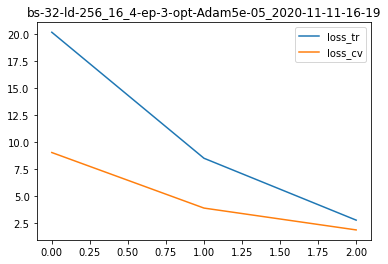

min =  1.885806
With Teacher Forcing
****************************************************************************************************
acc tf.Tensor(0.014008641, shape=(), dtype=float32)


369 ----> 495
407 ----> 447
445 ----> 418
483 ----> 449
521 ----> 497
559 ----> 541
597 ----> 581
635 ----> 618
673 ----> 653
711 ----> 690
749 ----> 727
787 ----> 768
825 ----> 809
863 ----> 849
901 ----> 888
939 ----> 926
977 ----> 964
1015 ----> 1003
1053 ----> 1041
1091 ----> 1079
1129 ---->    
1167 ---->    
1205 ---->    

true step: 38.0
mean pred step 30.74
median pred step 38.00
True length: 23.0
Predicted length: 20.0

 **************************************************************************************************** 

152 ----> 293
165 ----> 235
178 ----> 202
191 ----> 201
204 ----> 215
217 ----> 232
230 ----> 248
243 ----> 263
256 ----> 276
269 ----> 289
282 ---->    
295 ---->    
308 ---->    
321 ---->    
334 ---->    
347 ---->    

true step: 13.0
mean pred step -0.44
median p

In [13]:
def sort_key(x):
    try:
        id_str, model = x
        return min(model.track["loss_cv"])
    except:
        return 1e10


for id_str, ae in sorted(aes, key=sort_key):
    if len(ae.track["loss_cv"]) == 0: 
        continue


    for key in ae.track:
        if "loss" in key:
            plt.plot(ae.track[key], label=key)
    plt.legend()
    plt.title(id_str)
    plt.show()
    
    print("min = ", min(ae.track["loss_cv"]).numpy())

    print("With Teacher Forcing")
    show_reconsturction(ae, max_show=4)

    print("\n"*3)
    print("Without Teacher Forcing")
    show_reconsturction(ae,  max_show=4, teacher_forcing=False)
    print("\n"*8)

## Save models

In [14]:
save_seq_vae(ae, save_loc)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved/toy_seqs/models/encoder/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/models/decoder/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/models/len_decoder/assets
